In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import SphericalVoronoi, cKDTree
from scipy import sparse
import xarray as xr
import pandas as pd

from itertools import combinations

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx


from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)
import sys
import pickle
import copy
from glob import glob
from importlib import reload

sys.path.append('/science/users/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import community
import fieldsetter_cmems
import advectParticles

Stripy is not available on this machine.


In [2]:
reload(plot)
reload(community)
reload(fieldsetter_cmems)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/science/users/4302001/arctic-connectivity/tools/advectParticles.py'>

In [3]:
readDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030/"
meanDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/"
fieldFiles = sorted(glob(readDir + "mercatorglorys12v1_gl12_mean_*.nc"))

writedir = '/scratch/DaanR/psets/'

psetdir = "/data/oceanparcels/output_data/data_Daan/psets/"
matdir = "/data/oceanparcels/output_data/data_Daan/matrices/"
netdir = "/data/oceanparcels/output_data/data_Daan/networks/"
comdir = "/data/oceanparcels/output_data/data_Daan/communities/"

In [4]:
fieldset = fieldsetter_cmems.create(20010101, 1, antiBeach=False)

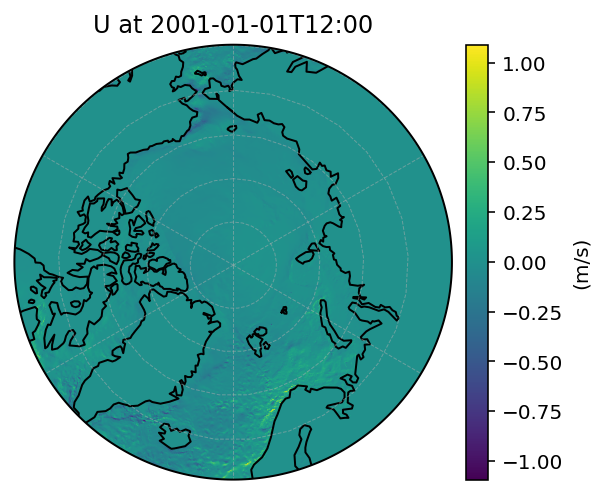

In [5]:
fig, ax = plot.from_field(fieldset.U, polar=True, land=False, latRange=(60,90))
plt.show()

In [6]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBins = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMask = community.hexMask(myBins, -180, 180, 60, 90)
myMask.growToLevel(4)
myBins.calculate_voronoi(myMask, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBins.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBins.oceanMask = pickle.load(pickFile)

In [50]:
myParts = community.particles.from_pickle('/scratch/DaanR/meshes/ico_mesh_parts_deg_arctic_r11_delland.pickle')
print("Number of particles:", myParts.n)

Number of particles: 1450665


In [10]:
# myBins.oceanMask_from_particles(myParts, fieldset=fieldset)
# with open("oceanMask_no_rim.pickle", "wb") as pickFile:
#     pickle.dump(myBins.oceanMask, pickFile)

In [51]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.initCount[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             units = "number of particles",
                                             size=(8,8))

AttributeError: 'hexCountBins' object has no attribute 'initCount'

# Loading the ensemble

In [102]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"
transMat = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7.npz")

In [103]:
onBoundary = np.ma.masked_array(np.zeros(myBins.bindex.shape), ~myBins.oceanMask)

In [104]:
ensembleCommunityID = {}
codelengths = []
globalMixing = []
globalCoherence = []
for run in range(1, 101):
    myBins.load_communities(comdir + f"infomap_ensemble/masked_network_{runName}_Cico7_mt2_multirunN{run}.clu")
    ensembleCommunityID[run-1] = myBins.communityID
    codelengths.append(myBins.codelength)
    
    myBins.find_adjacency();
    onBoundary = onBoundary + myBins.flag_on_boundary();
    myBins.color_communities();
    myBins.calculate_coherence_ratio(transMat);
    myBins.calculate_global_coherence()
    myBins.calculate_mixing(transMat);
    myBins.calculate_global_mixing()
    globalMixing.append(myBins.globalMixing)
    globalCoherence.append(myBins.globalCoherenceRatio)

In [7]:
qualityparametersDF = pd.DataFrame({"Codelength" : codelengths,
                                    "Global Mixing" : globalMixing,
                                    "Global Coherence" : globalCoherence}, 
                                )

In [8]:
qualityparametersDF.corr()

,Codelength,Global Mixing,Global Coherence
Codelength,1.000000,-0.460685,0.070669
Global Mixing,-0.460685,1.000000,-0.250830
Global Coherence,0.070669,-0.250830,1.000000


In [9]:
qualityparametersDF.var()

Codelength          0.000142
Global Mixing       0.000005
Global Coherence    0.000045
dtype: float64

In [8]:
# Masked values are equal!!
ensembleCommunityID[1][0] == ensembleCommunityID[2][0]

True

Text(0.5, 0, 'Codelength')

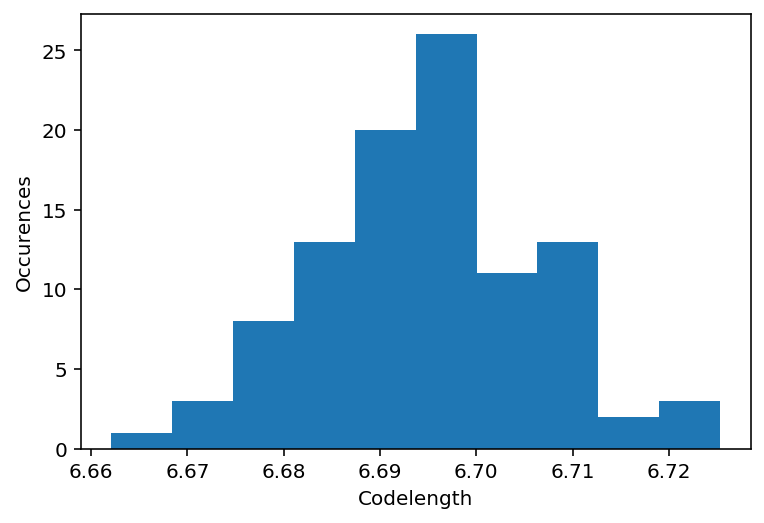

In [9]:
plt.hist(codelengths, bins=10)
plt.ylabel("Occurences")
plt.xlabel("Codelength")

# Jaccard Distances

In [10]:
# Find bindex to test for:
myBins.pointToIdx(-19.3, 70.9)

array([11312])

In [78]:
intersection = np.logical_and(ensembleCommunityID[1] == ensembleCommunityID[1][11312], ensembleCommunityID[2] == ensembleCommunityID[2][11312])
union = np.logical_or(ensembleCommunityID[1] == ensembleCommunityID[1][11312], ensembleCommunityID[2] == ensembleCommunityID[2][11312])
print("Intersection:", np.sum(intersection))
print("Union:", np.sum(union))

Intersection: 332
Union: 649


In [80]:
print("Jaccard distance",  np.sum(intersection)/np.sum(union))

Jaccard distance 0.5115562403697997


In [45]:
intersection.astype('int')

masked_array(data=[0, --, 0, ..., 1, 0, 0],
             mask=[False,  True, False, ..., False, False, False],
       fill_value=1)

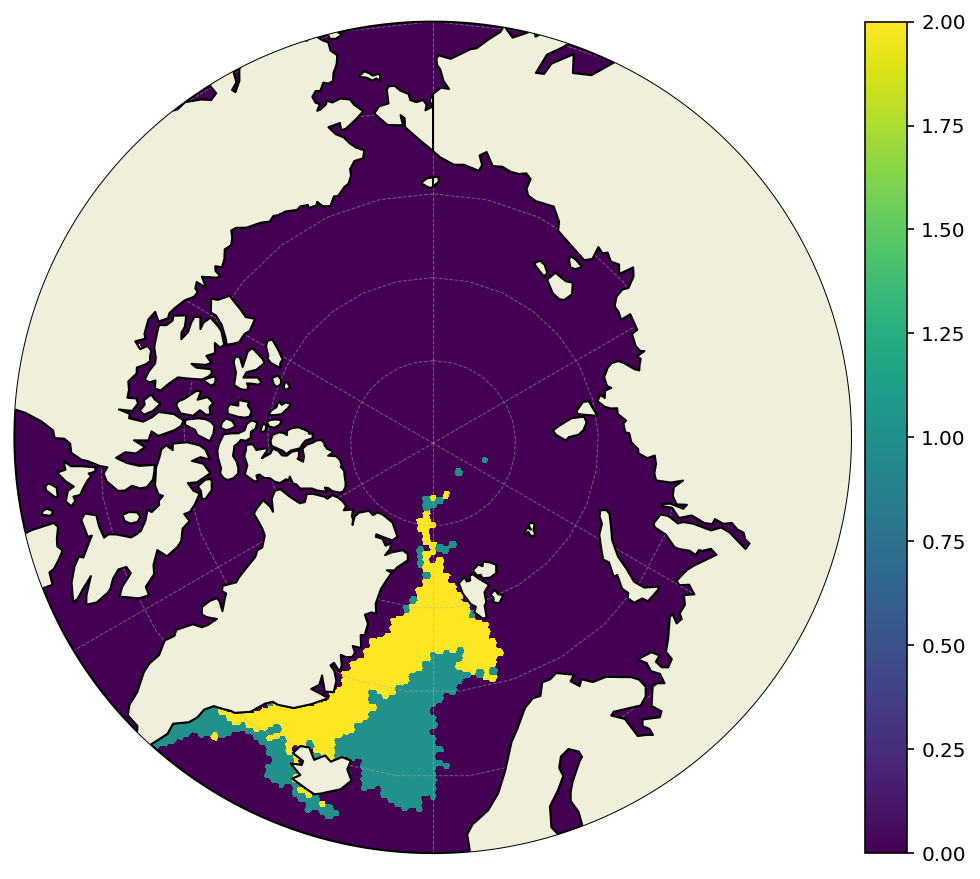

In [46]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             (intersection.astype('int')+union.astype('int'))[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (8,8),
                                             cbar = False,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 2,
                                            )

In [56]:
jaccardDistances = {}
for idx in myBins.bindex[myBins.oceanMask]:
    jaccarDistances[idx] = []
    for combo in combinations(ensembleCommunityID.keys(), 2):
        intersection = np.logical_and(ensembleCommunityID[combo[0]] == ensembleCommunityID[combo[0]][idx], ensembleCommunityID[combo[1]] == ensembleCommunityID[combo[1]][idx])
        union = np.logical_or(ensembleCommunityID[combo[0]] == ensembleCommunityID[combo[0]][idx], ensembleCommunityID[combo[1]] == ensembleCommunityID[combo[1]][idx])
        jaccardDistances[idx].append(np.sum(intersection)/np.sum(union))

4.26 s ± 60.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## loading Jaccard Distances pickle

In [15]:
with open("/data/oceanparcels/output_data/data_Daan/misc/jaccard_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_mt2_ensemble100.pickle", "rb") as pickFile:
    jaccardDistances = pickle.load(pickFile)

In [53]:
jaccardDistancesMean = np.zeros(myBins.bindex.shape)
jaccardDistancesVariance = np.zeros(myBins.bindex.shape)
for k, v in jaccardDistances.items():
    jaccardDistancesMean[k] = np.array(v).mean()

(array([5.752e+03, 3.000e+00, 1.520e+02, 7.300e+02, 1.367e+03, 1.393e+03,
        1.052e+03, 7.250e+02, 5.310e+02, 6.610e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

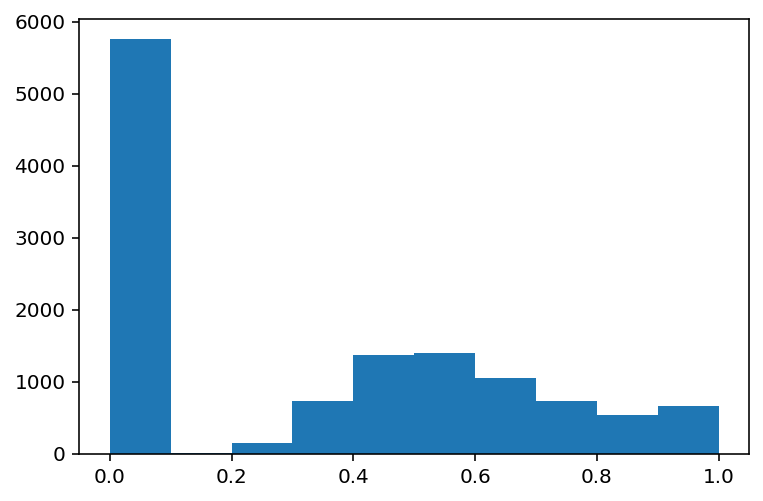

In [55]:
plt.hist(jaccardDistancesMean)

(array([746., 447., 273., 292., 704., 712., 835., 687., 224.,  30.]),
 array([0.02234637, 0.12011173, 0.21787709, 0.31564246, 0.41340782,
        0.51117318, 0.60893855, 0.70670391, 0.80446927, 0.90223464,
        1.        ]),
 <a list of 10 Patch objects>)

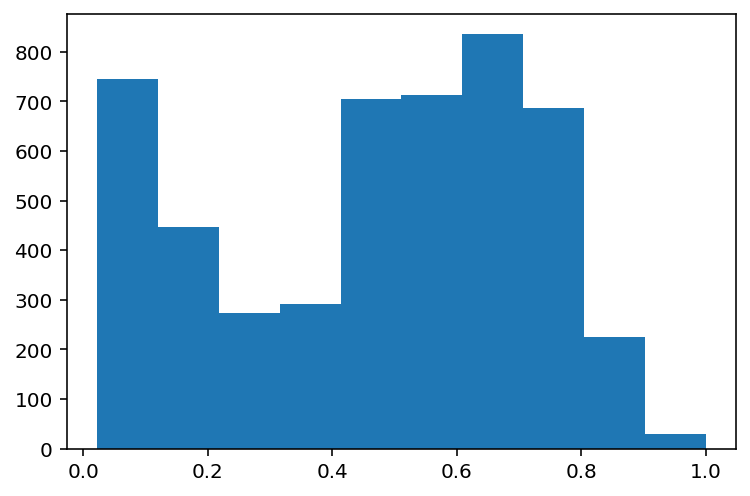

In [27]:
plt.hist(np.array(jaccardDistances[0]))

(array([   4.,   24.,   41.,   36.,   33.,  130.,  230.,  843., 2293.,
        1316.]),
 array([0.27777778, 0.35      , 0.42222222, 0.49444444, 0.56666667,
        0.63888889, 0.71111111, 0.78333333, 0.85555556, 0.92777778,
        1.        ]),
 <a list of 10 Patch objects>)

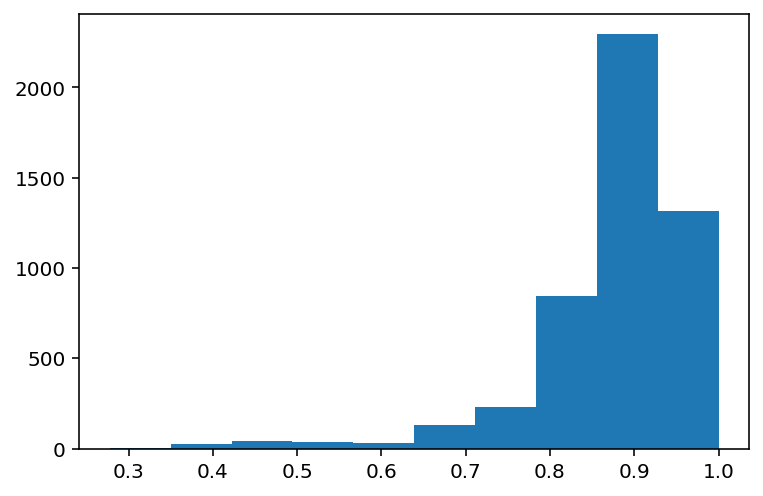

In [28]:
plt.hist(np.array(jaccardDistances[4]))

In [29]:
# Find bindex to test for:
myBins.pointToIdx(3, 75)

array([1898])

(array([873., 589., 561., 422., 507., 529., 591., 486., 280., 112.]),
 array([0.00781929, 0.10646375, 0.2051082 , 0.30375266, 0.40239712,
        0.50104157, 0.59968603, 0.69833049, 0.79697495, 0.8956194 ,
        0.99426386]),
 <a list of 10 Patch objects>)

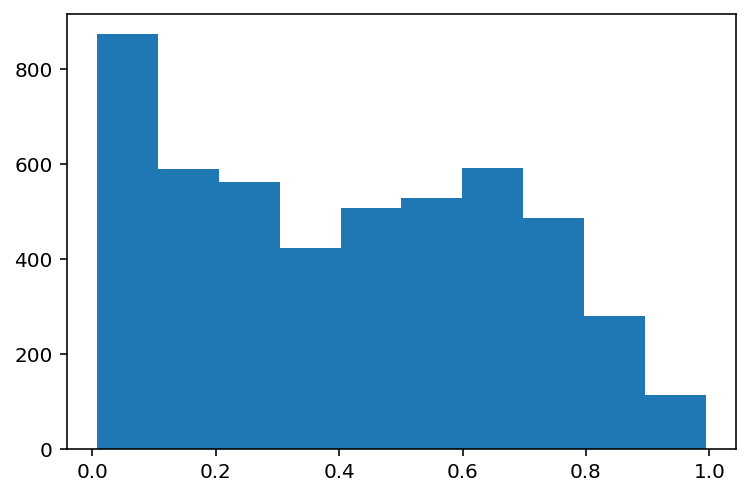

In [30]:
plt.hist(np.array(jaccardDistances[1898]))

In [18]:
ice_ds = xr.open_dataset(meanDir + "mercatorglorys12v1_gl12_mean_201803.nc")

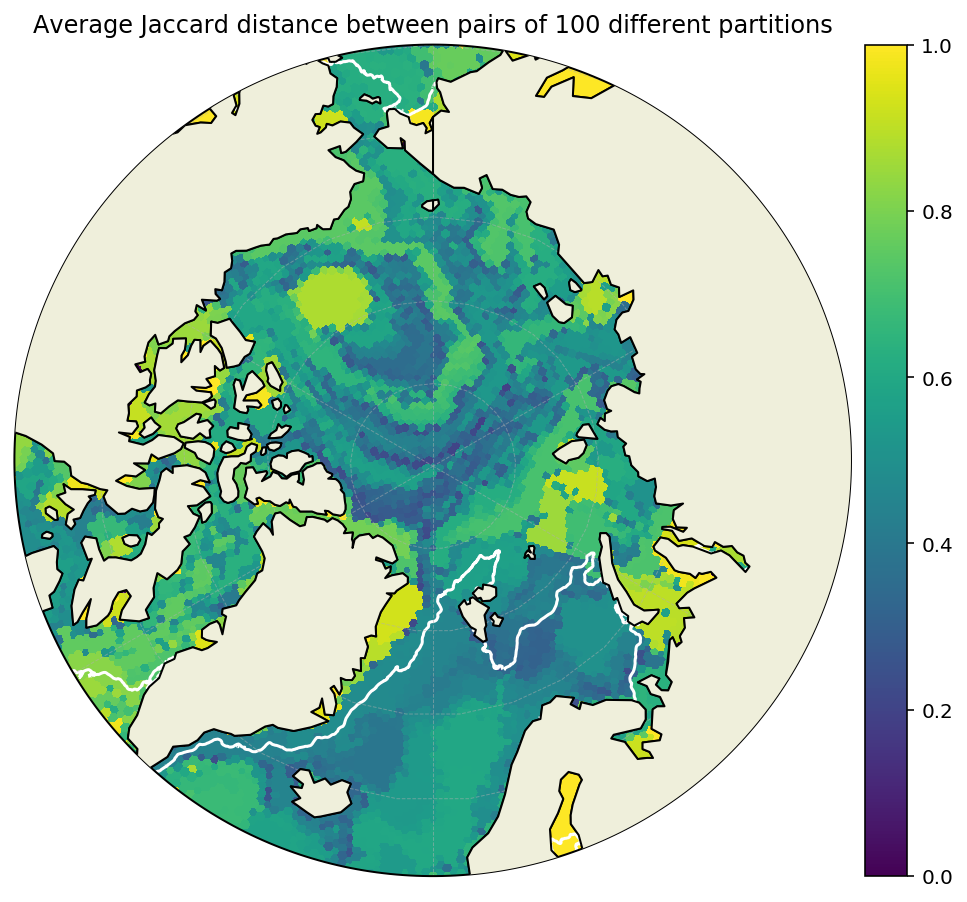

In [19]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             jaccardDistancesMean[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             land = True,
                                             title = "Average Jaccard distance between pairs of 100 different partitions",
                                             size=(8,8))
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())

In [72]:
%%time
nSolutionClusters = np.ma.masked_array(np.zeros(myBins.bindex.shape), ~myBins.oceanMask)
combos = list(combinations(list(range(0,100)), 2))
clSorter = np.argsort(codelengths)

tolerance = 0.25

for idx in myBins.bindex[myBins.oceanMask]:
    localJaccardDistances = jaccardDistances[idx].copy()
    sortedIdx = clSorter.tolist()
    clustered = []
    nClusters = 0
    while len(sortedIdx) > 0 and len(clustered) <= 95:
        clusterCenter = sortedIdx.pop(0)
        clustered.append(clusterCenter)
        nClusters += 1
        for unclustered in sortedIdx:
            if unclustered < clusterCenter:
                pair = (unclustered, clusterCenter)
            else:
                pair = (clusterCenter, unclustered)
            pairIdx = combos.index(pair)
            if jaccardDistances[idx][pairIdx] > 1 - tolerance:
                clustered.append(sortedIdx.pop(sortedIdx.index(unclustered)))
    nSolutionClusters[idx] = nClusters

CPU times: user 338 ms, sys: 2.04 ms, total: 340 ms
Wall time: 336 ms


In [73]:
nSolutionClusters

masked_array(data=[35.0, --, 7.0, ..., 0.0, 0.0, 0.0],
             mask=[False,  True, False, ..., False, False, False],
       fill_value=1e+20)

In [74]:
with open("/data/oceanparcels/output_data/data_Daan/misc/nclusters_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_mt2_ensemble100_threshold_0.25_95percent.pickle", "rb") as pickFile:
    nSolutionClusters = pickle.load(pickFile)

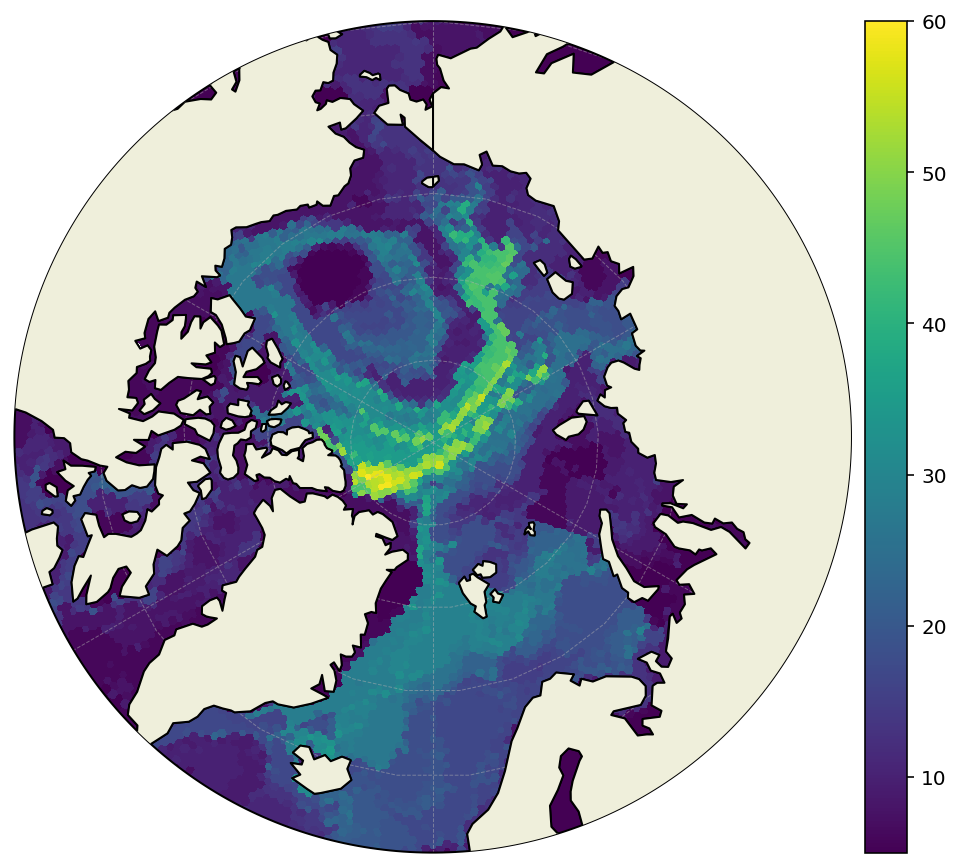

In [75]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             nSolutionClusters[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             land = True,
                                             cbar = True,
                                             size=(8,8))

In [81]:
poorJaccard = np.ma.masked_array(np.zeros(myBins.bindex.shape), ~myBins.oceanMask)
for k, v in jaccardDistances.items():
    poorJaccard[k] = np.sum(np.array(v) < 0.2)/len(v)

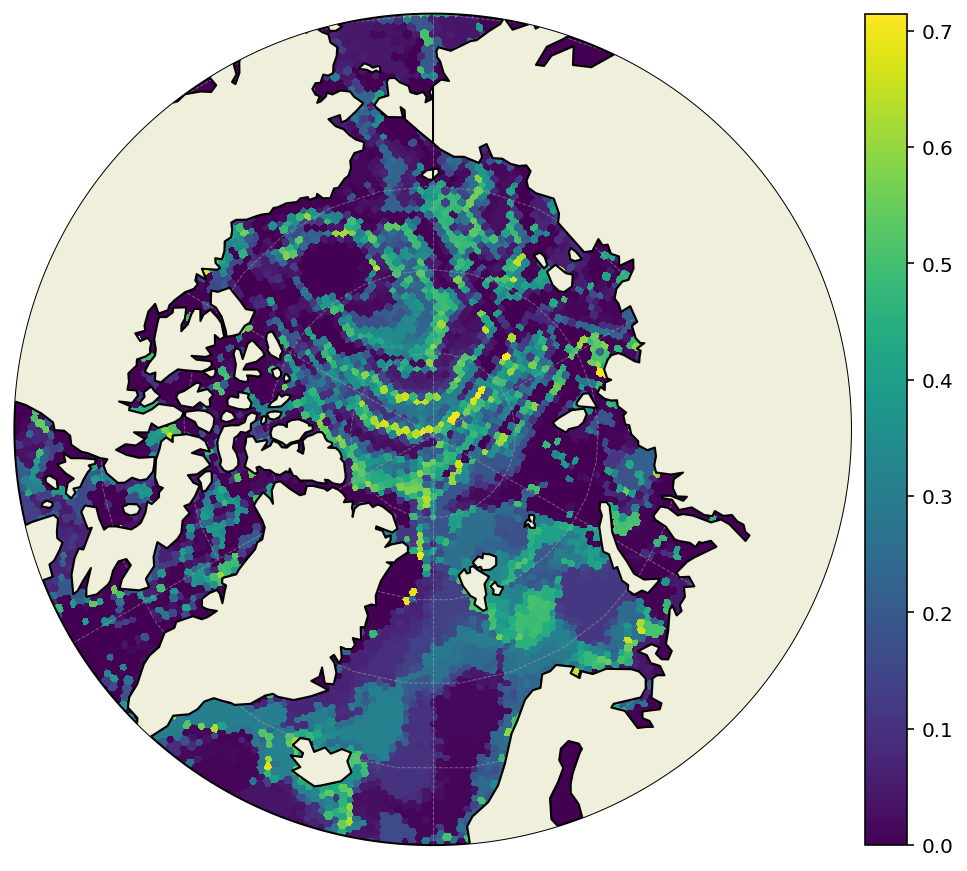

In [82]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             poorJaccard[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             land = True,
                                             cbar = True,
                                             size=(8,8))

# Co-occurance

In [8]:
from scipy import sparse, linalg

In [15]:
with open("/data/oceanparcels/output_data/data_Daan/misc/cooccurance_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_mt2_ensemble100.pickle", "rb") as pickFile:
    cooccurance = pickle.load(pickFile)/100

### Checking n connected sets

In [83]:
G_anyCooccurance = nx.from_numpy_matrix(cooccurance>0)
anyCooccuranceComponents = nx.connected_component_subgraphs(G_anyCooccurance)
anyCooccuranceComponentsDict = {idx: comp.nodes() for idx, comp in enumerate(anyCooccuranceComponents)}

In [89]:
connectedSet = np.ma.masked_array(np.zeros(myBins.bindex.shape), ~myBins.oceanMask)
for comp, nodes in anyCooccuranceComponentsDict.items():
    for node in list(nodes):
        connectedSet[myBins.bindex[myBins.oceanMask][node]] = comp
myBins.communityID = connectedSet
myBins.find_adjacency();
connectedSetColors = myBins.color_communities();

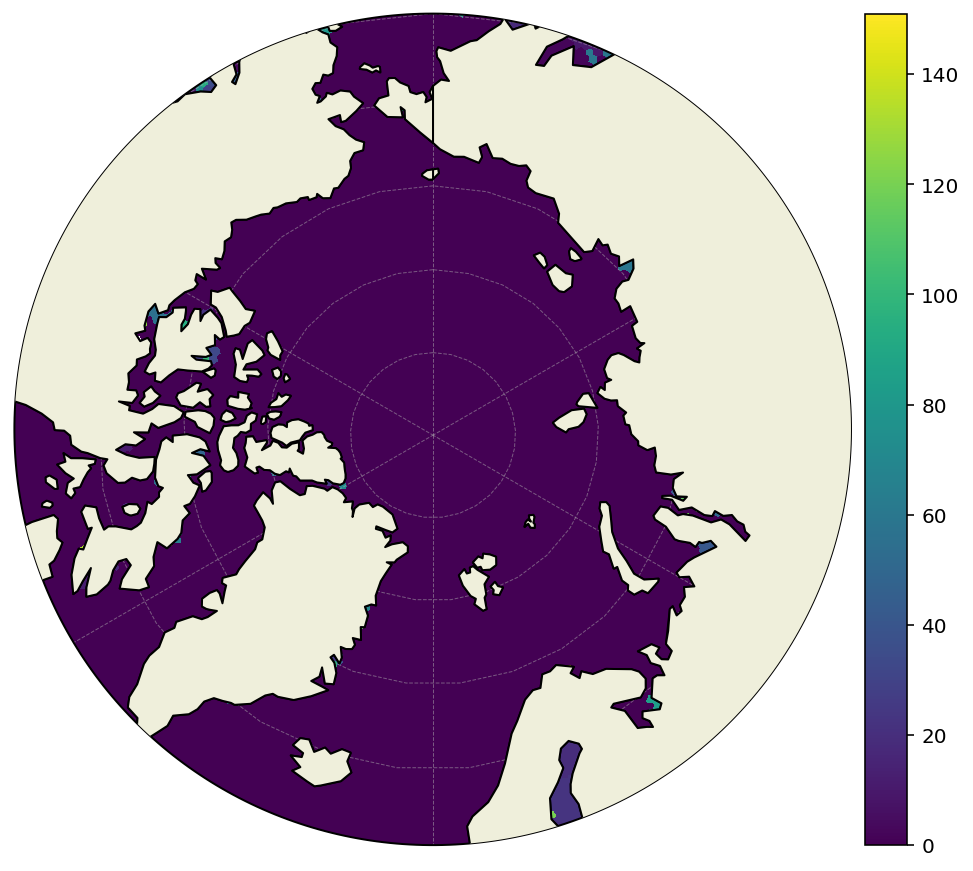

In [98]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             connectedSet[myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             land = True,
                                             cbar = True,
                                             size=(8,8))

In [99]:
G_strongCooccurance = nx.from_numpy_matrix(cooccurance>0.95)
strongCooccuranceComponents = nx.connected_component_subgraphs(G_strongCooccurance)
strongCooccuranceComponentsDict = {idx: comp.nodes() for idx, comp in enumerate(strongCooccuranceComponents)}

In [100]:
stronglyConnectedSet = np.ma.masked_array(np.zeros(myBins.bindex.shape), ~myBins.oceanMask)
for comp, nodes in strongCooccuranceComponentsDict.items():
    for node in list(nodes):
        stronglyConnectedSet[myBins.bindex[myBins.oceanMask][node]] = comp
myBins.communityID = stronglyConnectedSet
myBins.find_adjacency();
stronglyConnectedSetColors = myBins.color_communities();

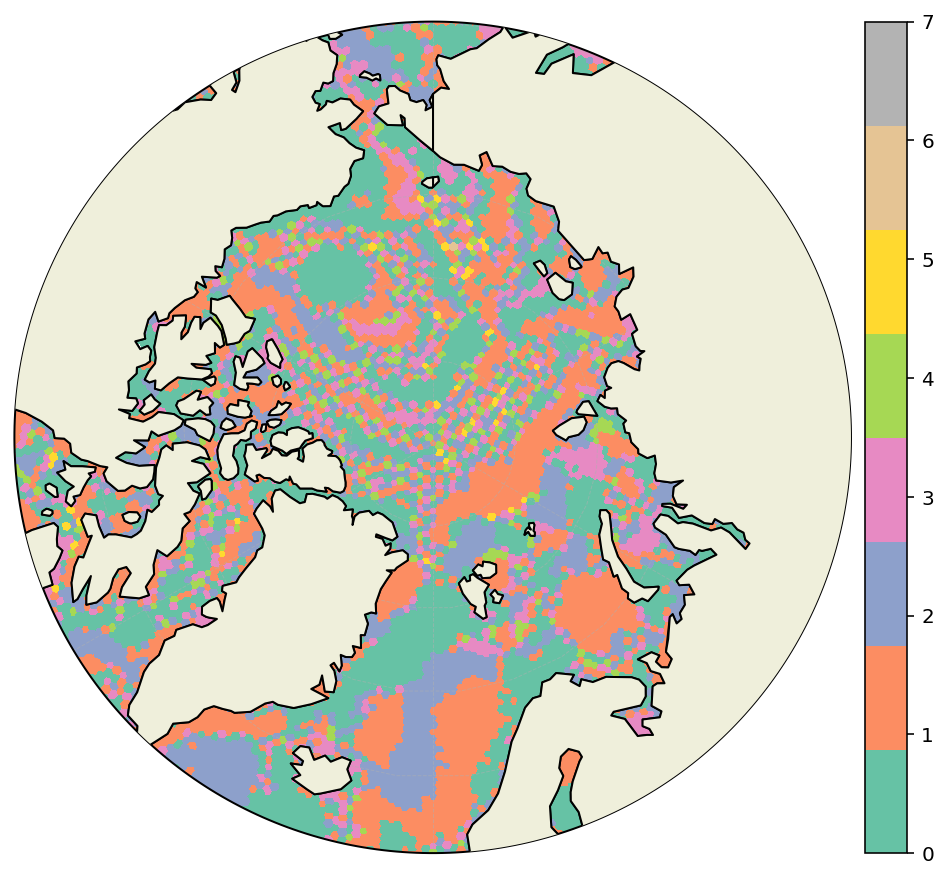

In [101]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             stronglyConnectedSetColors[myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             colormap = "Set2",
                                             polar = True,
                                             land = True,
                                             cbar = True,
                                             size=(8,8))

In [91]:
myBins.pointToIdx(5, 67)

array([6159])

In [92]:
myBins.pointToIdx(-17, 68)

array([3463])

In [93]:
stronglyConnectedSet[6159]

5.0

In [94]:
stronglyConnectedSet[3463]

5.0

### sparsity

In [11]:
np.sum(cooccurance == 0)/(cooccurance.shape[0]*cooccurance.shape[1])

0.9158743550919516

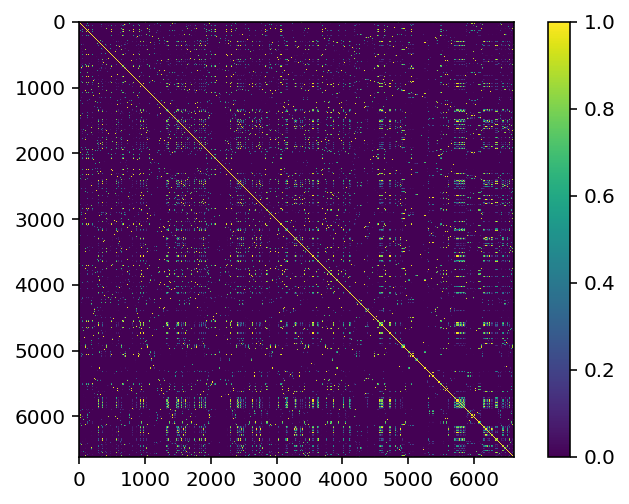

In [52]:
plt.imshow(cooccurance)
plt.colorbar()

In [13]:
D = np.diag(np.sum(cooccurance, axis=1))
L = D - cooccurance

In [14]:
la, v = linalg.eig(L)

In [19]:
v.shape

(6614, 6614)

In [23]:
sortr = np.argsort(la)

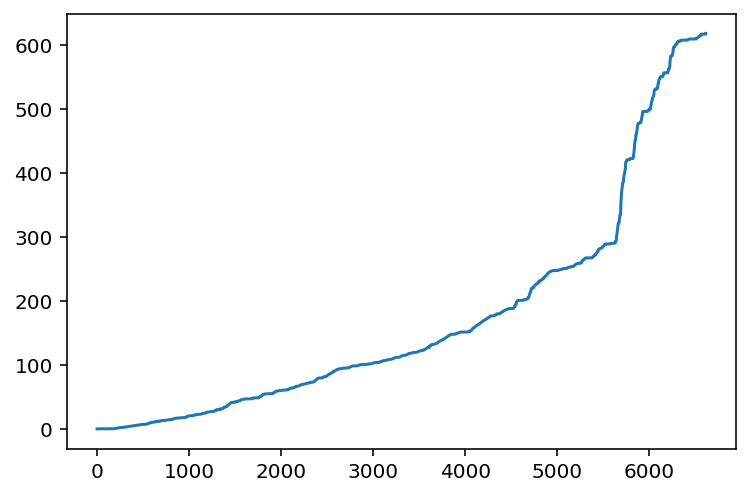

In [25]:
plt.plot(la[sortr])

In [28]:
v[:, sortr][:, 0]

array([-0.00014429+0.j, -0.00014429+0.j, -0.00014429+0.j, ...,
       -0.00014429+0.j, -0.00014429+0.j, -0.00014429+0.j])

In [42]:
G = nx.from_numpy_matrix(cooccurance)
nx.write_pajek(G, "graph_of_graphs")

In [48]:
myBins.load_communities("graph_of_graphs.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();

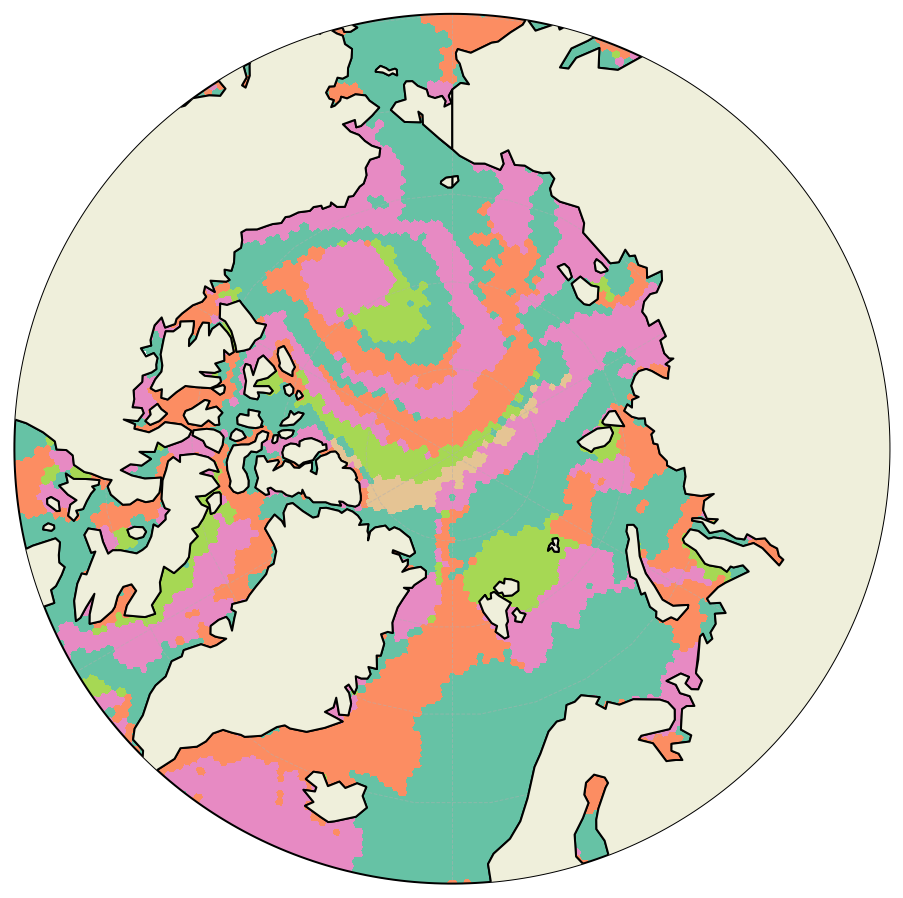

In [49]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             land = True,
                                             cbar = False,
                                             colormap = "Set2",
                                             size=(8,8))